In [1]:
import xgboost as xgb
import pandas as pd
print(f"xgboost version: {xgb.__version__}")
print(f"pandas version: {pd.__version__}")

xgboost version: 2.1.1
pandas version: 2.1.4


In [2]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.6 MB/s eta 0:00:00


# PRE - PROCESSING

## Import functions

In [3]:
!pip install meteostat

In [4]:
import holidays # For working with holiday data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from datetime import datetime
from meteostat import Stations, Daily # For working with weather data
from xgboost import plot_importance


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [5]:
## Features Functions

def create_datetime_features(df):
    """
    Creates time series features from datetime index
    Adapted from: https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost#Look-at-Worst-and-Best-Predicted-Days
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date'] = pd.to_datetime(df.index.date)
    return df

def get_holiday_features(df, country_code='US'):
    """
    Creates holiday features from datetime index
    """
    year_range = list(range(min(df.index.year), max(df.index.year) + 1))
    country_holidays = holidays.country_holidays(
        country_code,
        years=year_range,
        observed=False
    )
    holiday_df = pd.DataFrame(country_holidays.items())
    holiday_df.columns = ['date', 'holiday']
    holiday_df['date'] = pd.to_datetime(holiday_df['date'])
    return holiday_df

def get_weather_features(df, lat, lon):
    """
    Creates weather features based on latitude and longitude
    """
    room_temperature = 20  # Weather data is in Celsius
    start = min(df.index)
    end = max(df.index)

    stations = Stations()
    stations = stations.nearby(lat, lon)
    station = stations.fetch(1)

    # Get daily data
    weather_data = Daily(station['wmo'][0], start, end)
    weather_data = weather_data.fetch()
    weather_data = weather_data.dropna(axis=1)
    weather_data = weather_data.reset_index()
    weather_data['tmin_abs_diff_from_room_temperature'] = abs(weather_data['tmin'] - room_temperature)
    weather_data['tmax_abs_diff_from_room_temperature'] = abs(weather_data['tmax'] - room_temperature)
    weather_data = weather_data.rename(columns ={'time': 'date'})

    return weather_data

## Import data and feature engineering

In [6]:
main = 'https://raw.githubusercontent.com/Brunchcode/Forecasting-Energy-Consumption-Using-Machine-Learning/main/data/Timeseries/Timeseries_PJM_DOM_consumption_2006_to_2024.csv'

data_main = pd.read_csv(main,index_col=[0], parse_dates=[0])
data = create_datetime_features(data_main)
holiday_features = get_holiday_features(data)
weather_features = get_weather_features(data, 37.5407, -77.4360) # Richmond Capital of Virgina
data['datetime'] = data.index
data = data.merge(holiday_features, how='left', on='date')
data['holiday'] = data['holiday'].fillna('')
data = pd.get_dummies(data)
data = data.merge(weather_features, how='left', on='date')


remove_for_case_study = datetime(2020, 1, 1)
data_till_2019 = data.loc[data['datetime'] <= remove_for_case_study].copy()
case_study_data = data.loc[data['datetime'] > remove_for_case_study].copy()

In [7]:
data.head()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
0,9250.0,2006-01-01,0,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
1,8978.0,2006-01-01,1,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
2,8773.0,2006-01-01,2,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
3,8671.0,2006-01-01,3,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
4,8664.0,2006-01-01,4,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3


In [8]:
data.tail()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
162882,20498.376,2024-07-31,19,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162883,19814.648,2024-07-31,20,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162884,18910.259,2024-07-31,21,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162885,17645.255,2024-07-31,22,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162886,16421.592,2024-07-31,23,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2


In [9]:
data_till_2019.head()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
0,9250.0,2006-01-01,0,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
1,8978.0,2006-01-01,1,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
2,8773.0,2006-01-01,2,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
3,8671.0,2006-01-01,3,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3
4,8664.0,2006-01-01,4,6,1,1,2006,1,1,52,...,False,False,False,5.8,-1.1,11.7,0.0,4.0,21.1,8.3


In [10]:
data_till_2019.tail()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
122708,11442.870,2019-12-31,20,1,4,12,2019,365,31,1,...,False,False,False,10.9,5.0,13.9,0.0,11.9,15.0,6.1
122709,11166.770,2019-12-31,21,1,4,12,2019,365,31,1,...,False,False,False,10.9,5.0,13.9,0.0,11.9,15.0,6.1
122710,10838.550,2019-12-31,22,1,4,12,2019,365,31,1,...,False,False,False,10.9,5.0,13.9,0.0,11.9,15.0,6.1
122711,10592.674,2019-12-31,23,1,4,12,2019,365,31,1,...,False,False,False,10.9,5.0,13.9,0.0,11.9,15.0,6.1
122712,10364.707,2020-01-01,0,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8


In [11]:
case_study_data.head()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
122713,10291.858,2020-01-01,1,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122714,10252.082,2020-01-01,2,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122715,10303.804,2020-01-01,3,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122716,10588.920,2020-01-01,4,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122717,10980.540,2020-01-01,5,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8


In [12]:
case_study_data.tail()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
162882,20498.376,2024-07-31,19,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162883,19814.648,2024-07-31,20,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162884,18910.259,2024-07-31,21,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162885,17645.255,2024-07-31,22,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162886,16421.592,2024-07-31,23,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2


# SHAP

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from joblib import dump, load
from datetime import datetime

# Step 0: Set the global random seed
np.random.seed(22)

# Step 1: Data Preprocessing and Normalization using Min-Max Scaling
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
import shap
from joblib import load
from sklearn.preprocessing import MinMaxScaler

# Load models
best_xgb = load('/content/xgb_best_model_grid_search2.joblib')


X_test_sample = X_test_scaled[:100]

In [16]:
# Initialize SHAP explainer for Random Forest
explainer_xgb = shap.TreeExplainer(best_xgb)

# Compute SHAP values for the sample test data
shap_values_xgb = explainer_xgb.shap_values(X_test_sample)

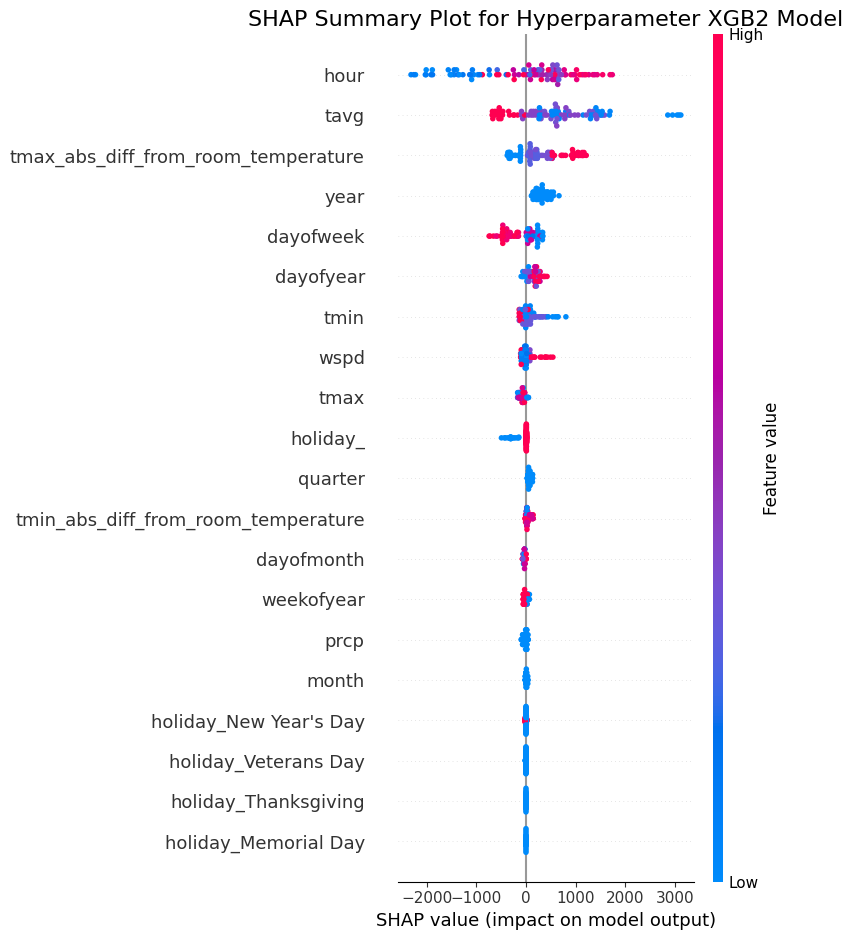

In [17]:
import shap
import matplotlib.pyplot as plt

# Create the SHAP summary plot for XGBoost model with a custom title
plt.figure(figsize=(10,6))

# Generate SHAP plot
shap.summary_plot(shap_values_xgb, X_test_sample, feature_names=X_test.columns, show=False)

# Add a title manually
plt.title("SHAP Summary Plot for Hyperparameter XGB2 Model", fontsize=16)

# Display the plot
plt.tight_layout()  # Ensure the layout is neat
plt.show()
